In [1]:
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

# Diretório das imagens processadas
output_dir = "/mnt/d/Documentos Gustavo/TCC/processed_heatmaps3"

# Listar IDs dos pacientes
healthy_patients = [p for p in os.listdir(os.path.join(output_dir, "Healthy")) if os.path.isdir(os.path.join(output_dir, "Healthy", p))]
sick_patients = [p for p in os.listdir(os.path.join(output_dir, "Sick")) if os.path.isdir(os.path.join(output_dir, "Sick", p))]

# Garantir aleatoriedade na separação
random.seed(42)
random.shuffle(healthy_patients)
random.shuffle(sick_patients)

# Descobrir o menor grupo
min_count = min(len(healthy_patients), len(sick_patients))
print('Por classe', min_count)
# Cortar ambos os grupos para o tamanho mínimo (balanceamento)
healthy_patients = healthy_patients[:min_count]
sick_patients = sick_patients[:min_count]

# Definir proporções (70% treino, 15% validação, 15% teste)
train_healthy, temp_healthy = train_test_split(healthy_patients, test_size=0.3, random_state=42)
val_healthy, test_healthy = train_test_split(temp_healthy, test_size=0.5, random_state=42)

train_sick, temp_sick = train_test_split(sick_patients, test_size=0.3, random_state=42)
val_sick, test_sick = train_test_split(temp_sick, test_size=0.5, random_state=42)

# Transformação das imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset personalizado para carregar 3 imagens por paciente
class CustomPatientDataset(Dataset):
    def __init__(self, patient_list, root_dir, transform=None):
        self.patient_list = patient_list
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {"Healthy": 0, "Sick": 1}  # Rotulação

    def __len__(self):
        return len(self.patient_list)

    def __getitem__(self, idx):
        patient_id = self.patient_list[idx]
        
        # Determinar a classe do paciente (Healthy ou Sick)
        for category in ["Healthy", "Sick"]:
            patient_path = os.path.join(self.root_dir, category, patient_id)
            if os.path.exists(patient_path):
                label = self.classes[category]
                break

        # Listar imagens do paciente
        image_paths = [os.path.join(patient_path, img) for img in os.listdir(patient_path) if img.endswith(".jpg")]

        # Selecionar corretamente as imagens com base na 3ª parte da nomenclatura
        selected_images = {}
        for img in image_paths:
            partes = os.path.basename(img).split(".")
            if len(partes) >= 4:
                tipo = partes[2]  # A 3ª parte da nomenclatura indica o tipo da imagem
                if tipo in ["1", "3", "5"]:  # 1 = Frontal, 3 = Lateral esquerda, 5 = Lateral direita
                    selected_images[tipo] = img

        # Verificar se temos todas as imagens necessárias
        if not all(k in selected_images for k in ["1", "3", "5"]):
            raise ValueError(f"Paciente {patient_id} não possui todas as imagens necessárias!")

        # Carregar imagens e aplicar transformações
        images = [self.transform(Image.open(selected_images[k]).convert("RGB")) for k in ["1", "3", "5"]]

        # Concatenar para criar tensor de entrada (3 x C x H x W)
        images_tensor = torch.stack(images)

        return images_tensor, label

# Criar datasets de treino, validação e teste
train_dataset = CustomPatientDataset(train_healthy + train_sick, output_dir, transform)
val_dataset = CustomPatientDataset(val_healthy + val_sick, output_dir, transform)
test_dataset = CustomPatientDataset(test_healthy + test_sick, output_dir, transform)

# Criar DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Exibir quantidades finais
print(f"Tamanho do conjunto de treino: {len(train_dataset)} pacientes")
print(f"Tamanho do conjunto de validação: {len(val_dataset)} pacientes")
print(f"Tamanho do conjunto de teste: {len(test_dataset)} pacientes")


Por classe 120
Tamanho do conjunto de treino: 168 pacientes
Tamanho do conjunto de validação: 36 pacientes
Tamanho do conjunto de teste: 36 pacientes


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from datetime import datetime

# Configurar uso de GPU (se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ResNet50Modificada(nn.Module):
    def __init__(self):
        super(ResNet50Modificada, self).__init__()
        self.num_subnets = 3
        self.num_features = 1024 
        self.subnets = nn.ModuleList([self._create_subnet() for _ in range(self.num_subnets)])

        self.fc_final = nn.Sequential(
            nn.Linear(self.num_subnets * self.num_features, 128),  # Primeira camada
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Camada final (saída de 2 neurônios para classificação binária)
        )

    def _create_subnet(self):
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = base_model.fc.in_features  # Obter número de features da Resnet50

        # Modificar a camada fully connected de cada subnet
        base_model.fc = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024)
        )
        return base_model

    def forward(self, x):
        outputs = []
        for i in range(self.num_subnets):
            img = x[:, i, :, :, :]  # Selecionar a i-ésima imagem do batch
            outputs.append(self.subnets[i](img))  # Passar pela sub-rede correspondente
        
        concat = torch.cat(outputs, dim=1)  # Concatenar as saídas das sub-redes
        return self.fc_final(concat)  # Passar pela camada final

# Número de execuções e épocas
num_execucoes = 5
num_epochs = 30

# Listas para armazenar métricas de cada execução
accuracies = []
all_preds = []
all_probs = []

total_start_time = datetime.now()
for execucao in range(num_execucoes):
    print(f"\n🚀 Treinando Execução {execucao+1}/{num_execucoes}...\n")

    modelo = ResNet50Modificada().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001, weight_decay=1e-4)

    # Early Stopping Configuração
    best_val_loss = float('inf')
    patience = 10
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0

        for imagens, labels in train_loader:
            imagens, labels = imagens.to(device), labels.to(device)

            # Não concatenamos as imagens! Apenas passamos normalmente para o modelo
            optimizer.zero_grad()
            output = modelo(imagens)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validação
        modelo.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for imagens, labels in val_loader:
                imagens, labels = imagens.to(device), labels.to(device)

                output = modelo(imagens)
                loss = loss_fn(output, labels)
                val_loss += loss.item()

                _, predicted = torch.max(output, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.2f}%")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(modelo.state_dict(), f"best_model_execucao_{execucao+1}.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("🛑 Early Stopping ativado!")
                break

    # Avaliação no conjunto de teste
    modelo.load_state_dict(torch.load(f"best_model_execucao_{execucao+1}.pth"))
    modelo.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for imagens, labels in test_loader:
            imagens, labels = imagens.to(device), labels.to(device)

            output = modelo(imagens)
            probs = torch.softmax(output, dim=1)[:, 1]  # Probabilidades da classe 1 (positiva)
            _, preds = torch.max(output, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy()) 
            y_prob.extend(probs.cpu().numpy()) 


    # Armazenar predições (probabilidades da classe positiva) para modelo médio
    all_preds.append(y_pred)
    all_probs.append(y_prob)

    # Armazenar acurácia binarizando as probabilidades
    preds_binarias = np.array(y_pred).round().astype(int)
    acc = (np.array(y_true) == preds_binarias).mean()
    accuracies.append(acc)
    print(f"✅ Execução {execucao+1} finalizada! Acurácia: {acc:.4f}")

    # 🚀 Liberação de memória após cada execução
    del modelo, optimizer, loss_fn
    torch.cuda.empty_cache()  # Libera memória da GPU

# Salvar predições e labels para análise posterior
np.save("all_preds.npy", all_preds)
np.save("all_probs.npy", all_probs)
np.save("y_true.npy", y_true)

total_end_time = datetime.now()
print(f"\n🎯 Treinamento completo! Tempo total: {total_end_time - total_start_time}")



🚀 Treinando Execução 1/5...

Epoch 1/30 | Train Loss: 0.5312 | Val Loss: 0.4505 | Val Acc: 80.56%
Epoch 2/30 | Train Loss: 0.5079 | Val Loss: 5.0418 | Val Acc: 80.56%
Epoch 3/30 | Train Loss: 0.4360 | Val Loss: 0.5439 | Val Acc: 80.56%
Epoch 4/30 | Train Loss: 0.3589 | Val Loss: 0.6855 | Val Acc: 83.33%
Epoch 5/30 | Train Loss: 0.3746 | Val Loss: 2.1187 | Val Acc: 55.56%
Epoch 6/30 | Train Loss: 0.3754 | Val Loss: 0.5169 | Val Acc: 77.78%
Epoch 7/30 | Train Loss: 0.4338 | Val Loss: 0.4393 | Val Acc: 80.56%
Epoch 8/30 | Train Loss: 0.4140 | Val Loss: 0.3170 | Val Acc: 83.33%
Epoch 9/30 | Train Loss: 0.2829 | Val Loss: 0.3367 | Val Acc: 80.56%
Epoch 10/30 | Train Loss: 0.2780 | Val Loss: 0.3671 | Val Acc: 86.11%
Epoch 11/30 | Train Loss: 0.3118 | Val Loss: 4.4500 | Val Acc: 50.00%
Epoch 12/30 | Train Loss: 0.2836 | Val Loss: 0.7117 | Val Acc: 80.56%
Epoch 13/30 | Train Loss: 0.3217 | Val Loss: 0.3359 | Val Acc: 83.33%
Epoch 14/30 | Train Loss: 0.2707 | Val Loss: 0.3325 | Val Acc: 86.11%

/tmp/ipykernel_13526/2489864120.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load(f"best_model_execucao_{execucao+1}.pth"))


✅ Execução 1 finalizada! Acurácia: 0.7500

🚀 Treinando Execução 2/5...

Epoch 1/30 | Train Loss: 0.5943 | Val Loss: 4.2945 | Val Acc: 80.56%
Epoch 2/30 | Train Loss: 0.3798 | Val Loss: 0.4766 | Val Acc: 77.78%
Epoch 3/30 | Train Loss: 0.3572 | Val Loss: 0.4896 | Val Acc: 86.11%
Epoch 4/30 | Train Loss: 0.3195 | Val Loss: 0.2888 | Val Acc: 94.44%
Epoch 5/30 | Train Loss: 0.2777 | Val Loss: 0.3334 | Val Acc: 83.33%
Epoch 6/30 | Train Loss: 0.2448 | Val Loss: 0.3176 | Val Acc: 83.33%
Epoch 7/30 | Train Loss: 0.2039 | Val Loss: 0.4778 | Val Acc: 86.11%
Epoch 8/30 | Train Loss: 0.2224 | Val Loss: 0.4751 | Val Acc: 91.67%
Epoch 9/30 | Train Loss: 0.2706 | Val Loss: 1.5628 | Val Acc: 80.56%
Epoch 10/30 | Train Loss: 0.3251 | Val Loss: 1.2390 | Val Acc: 83.33%
Epoch 11/30 | Train Loss: 0.2197 | Val Loss: 1.8924 | Val Acc: 80.56%
Epoch 12/30 | Train Loss: 0.1714 | Val Loss: 0.4111 | Val Acc: 86.11%
Epoch 13/30 | Train Loss: 0.1525 | Val Loss: 0.3377 | Val Acc: 77.78%
Epoch 14/30 | Train Loss: 0


===== 📊 MÉTRICAS DO MODELO MÉDIO =====
✅ Accuracy: 0.8333
✅ Sensitivity (Recall): 0.7778
✅ Specificity: 0.8889
✅ Precision: 0.8750
✅ F1-score: 0.8235


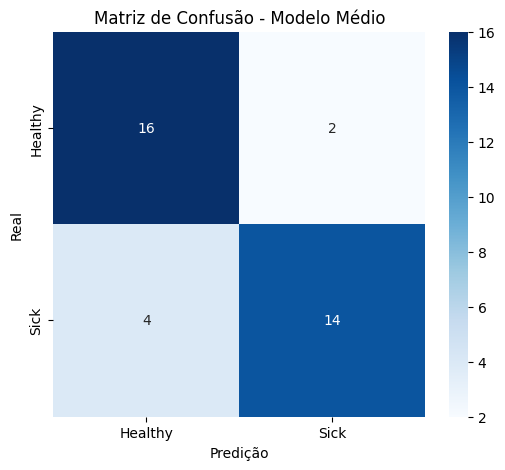

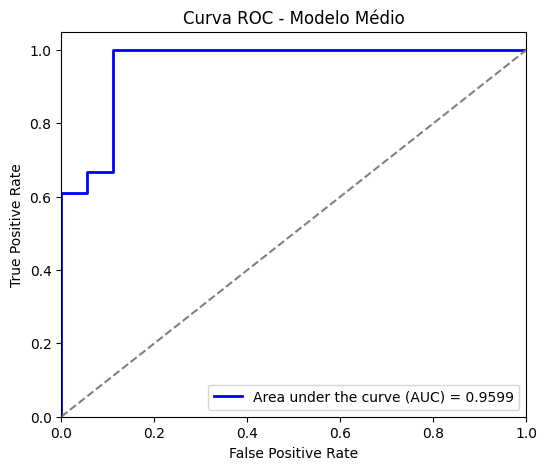

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Carregar predições salvas
all_preds = np.load("all_preds.npy")
y_true = np.load("y_true.npy")

# Calcular modelo médio por votação
final_preds = np.mean(np.array(all_preds), axis=0).round().astype(int)

# Gerar matriz de confusão
conf_matrix_final = confusion_matrix(y_true, final_preds)
tn, fp, fn, tp = conf_matrix_final.ravel()

# Calcular métricas do modelo médio
accuracy_final = accuracy_score(y_true, final_preds)
precision_final = precision_score(y_true, final_preds, average="binary")
recall_final = recall_score(y_true, final_preds, average="binary")
specificity_final = tn / (tn + fp)
f1_final = f1_score(y_true, final_preds, average="binary")

# Exibir métricas do modelo médio
print("\n===== 📊 MÉTRICAS DO MODELO MÉDIO =====")
print(f"✅ Accuracy: {accuracy_final:.4f}")
print(f"✅ Sensitivity (Recall): {recall_final:.4f}")
print(f"✅ Specificity: {specificity_final:.4f}")
print(f"✅ Precision: {precision_final:.4f}")
print(f"✅ F1-score: {f1_final:.4f}")

# Exibir matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_final, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "Sick"],
            yticklabels=["Healthy", "Sick"])
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo Médio")
plt.show()

# Calcular curva ROC
all_probs = np.load("all_probs.npy")
fpr, tpr, _ = roc_curve(y_true, np.mean(np.array(all_probs), axis=0))
roc_auc = auc(fpr, tpr)

# #Experimento
# mean_probs = np.mean(np.array(all_probs), axis=0)
# print(np.unique(mean_probs))

# Exibir curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area under the curve (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo Médio')
plt.legend(loc='lower right')
plt.show()

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Carregar predições salvas
all_preds = np.load("all_preds.npy")
y_true = np.load("y_true.npy")

# Lista para armazenar métricas individuais
accuracies = []
precisions = []
recalls = []
specificities = []
f1_scores = []

# Calcular métricas para cada modelo individual
for preds in all_preds:
    preds = np.array(preds).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    
    accuracies.append(accuracy_score(y_true, preds))
    precisions.append(precision_score(y_true, preds))
    recalls.append(recall_score(y_true, preds))
    specificities.append(tn / (tn + fp))
    f1_scores.append(f1_score(y_true, preds))

# Calcular desvio padrão
print("\n===== 📊 MÉTRICAS POR MODELO =====")
print(f"Accuracy: Desvio Padrão={np.std(accuracies):.4f}")
print(f"Sensitivity (Recall): Desvio Padrão={np.std(recalls):.4f}")
print(f"Specificity: Desvio Padrão={np.std(specificities):.4f}")
print(f"Precision: Desvio Padrão={np.std(precisions):.4f}")
print(f"F1-score: Desvio Padrão={np.std(f1_scores):.4f}")


===== 📊 MÉTRICAS POR MODELO =====
Accuracy: Desvio Padrão=0.0444
Sensitivity (Recall): Desvio Padrão=0.1548
Specificity: Desvio Padrão=0.1089
Precision: Desvio Padrão=0.0918
F1-score: Desvio Padrão=0.0579
